In [1]:
!pip install -U albumentations
!pip install ttach
!pip install torch-lr-finder

Requirement already up-to-date: albumentations in /usr/local/lib/python3.7/dist-packages (1.0.1)


In [2]:
!git clone "https://github.com/jacobgil/pytorch-grad-cam.git"
!git clone "https://github.com/vvshankar78/DeepLearning.git"

fatal: destination path 'pytorch-grad-cam' already exists and is not an empty directory.
fatal: destination path 'DeepLearning' already exists and is not an empty directory.


In [3]:
import sys, os

# /content/DeepLearning/Extensive VisionAI-EVA6/
my_path = 'DeepLearning/Extensive VisionAI-EVA6/09_Custom_Resnet'
sys.path.append(my_path)
# os.listdir(my_path)

my_path_cam = '/content/pytorch-grad-cam'
sys.path.append(my_path_cam)

In [4]:
from __future__ import print_function
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torchsummary import summary
import matplotlib
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

In [5]:
import matplotlib.pyplot as plt
import numpy as np
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.optim.lr_scheduler import ExponentialLR
from torch.optim.lr_scheduler import StepLR

In [6]:
# from model import Net2
from models import Resnet
from models import my_model
from train import train
from test1 import test
from config import ModelConfig
from utils import *
from data.data_engine import DataEngine

In [8]:
# View model config
args = ModelConfig()
args.dropout_value = 0.0
args.print_config()

Model Parameters:
{ 'batch_size_cpu': 512,
  'batch_size_cuda': 512,
  'dropout_value': 0.0,
  'epochs': 50,
  'num_workers': 4,
  'seed': 1}
Model Parameters:
{ 'batch_size_cpu': 512,
  'batch_size_cuda': 512,
  'dropout_value': 0.0,
  'epochs': 50,
  'num_workers': 4,
  'seed': 1}



Extracting ./../data/cifar-10-python.tar.gz to ./../data
Files already downloaded and verified


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


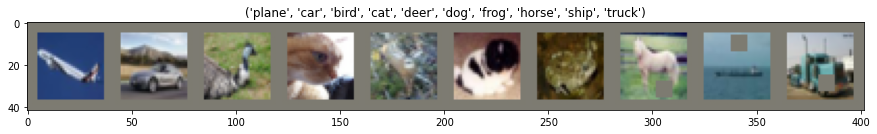

In [9]:
data = DataEngine(args)
data.show_samples()

In [10]:
train_loader = data.train_loader
test_loader = data.test_loader

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

SEED = 1
# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

#dict to store model loss and accuracy parameters
history = {}

CUDA Available? True


In [11]:


class Net2(nn.Module):


    def ResBlock(self, in_features, out_features, pading=1):
      # convolution
      layers = []
      layers = [nn.Conv2d(in_features, out_features, 3, padding=pading, bias=False),nn.BatchNorm2d(out_features), nn.ReLU(),
                nn.Conv2d(out_features, out_features, 3, padding=pading, bias=False),nn.BatchNorm2d(out_features), nn.ReLU()]
      return nn.Sequential(*layers)

    def max_pool_block(self, in_features, out_features, pading=1):
        layers = []
        layers = [nn.Conv2d(in_features, out_features, 3, padding=pading, bias=False), nn.MaxPool2d(2,2), nn.BatchNorm2d(out_features), nn.ReLU()]
        return nn.Sequential(*layers)


    def __init__(self):
        super(Net2, self).__init__()
        self.convblock0 = nn.Sequential(nn.Conv2d(3,64, 3, padding=1, bias=False),nn.BatchNorm2d(64), nn.ReLU()) #38
        self.pool1 = self.max_pool_block(64,128)  #19
        self.convblock1 = self.ResBlock(128,128) #19
        self.pool2 = self.max_pool_block(128,256)  #9   
        self.pool3 = self.max_pool_block(256,512)  #4             
        self.convblock2 = self.ResBlock(512,512) #4
        

        # self.gap = nn.Sequential(nn.AvgPool2d(kernel_size=4)) # output_size = 1
        self.max_pool = nn.MaxPool2d(4,4)
        self.fc1 = nn.Linear(512, 10)

    def forward(self, x):
        x = self.convblock0(x)
        x = self.pool1(x)
        x1 = self.convblock1(x)
        x = x+ x1
        x = self.pool2(x)
        x = self.pool3(x)
        x2 = self.convblock2(x)
        x = x + x2

        
        # print(x.shape)
        # x = self.gap(x)
        x = self.max_pool(x)
        # print(x.shape)
        x = x.view(-1,512)
        x = self.fc1(x)
        x = x.view(-1,10)
        return F.log_softmax(x, dim=-1)


In [13]:
model = Net2().to(device)
summary(model, input_size=(3, 38, 38))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 38, 38]           1,728
       BatchNorm2d-2           [-1, 64, 38, 38]             128
              ReLU-3           [-1, 64, 38, 38]               0
            Conv2d-4          [-1, 128, 38, 38]          73,728
         MaxPool2d-5          [-1, 128, 19, 19]               0
       BatchNorm2d-6          [-1, 128, 19, 19]             256
              ReLU-7          [-1, 128, 19, 19]               0
            Conv2d-8          [-1, 128, 19, 19]         147,456
       BatchNorm2d-9          [-1, 128, 19, 19]             256
             ReLU-10          [-1, 128, 19, 19]               0
           Conv2d-11          [-1, 128, 19, 19]         147,456
      BatchNorm2d-12          [-1, 128, 19, 19]             256
             ReLU-13          [-1, 128, 19, 19]               0
           Conv2d-14          [-1, 256,

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


In [14]:
# from torch_lr_finder import LRFinder

# criterion = nn.CrossEntropyLoss()
# optimizer = optim.SGD(model.parameters(), lr=1e-7, weight_decay=1e-2)
# lr_finder = LRFinder(model, optimizer, criterion, device="cuda")
# lr_finder.range_test(train_loader, end_lr=100, num_iter=100, step_mode="exp")

# lr_finder.plot()

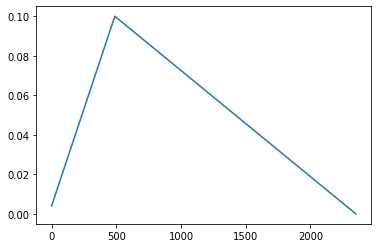

In [18]:
# optimizer = torch.optim.SGD(model.parameters(), lr=0.1)
peak = 5 # epoch you want the max lr. 
EPOCHS = 24
peak_pct = peak/EPOCHS
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=1e-7, weight_decay=1e-2)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.1, steps_per_epoch=98, epochs=24,
                                                pct_start=peak_pct, 
                                                anneal_strategy='linear')
lrs = []


for i in range(EPOCHS*len(train_loader)):
    optimizer.step()
    lrs.append(optimizer.param_groups[0]["lr"])
#     print("Factor = ",i," , Learning Rate = ",optimizer.param_groups[0]["lr"])
    scheduler.step()

plt.plot(lrs)

In [19]:
# Input parameters for the model
EPOCHS = 24
l1_decay=0.000
l2_decay=0.0
peak = 5 # epoch you want the max lr. 
EPOCHS = 24
peak_pct = peak/EPOCHS

lrs = []

# model = Net().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
# scheduler = StepLR(optimizer, step_size=25, gamma=0.5)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.1, steps_per_epoch=len(train_loader),
                                                epochs=EPOCHS,
                                                pct_start=peak_pct, 
                                                anneal_strategy='linear')

# run_model(model, optimizer, scheduler, EPOCHS, l1=0.0, l2=0.0)

train_loss_list = []
train_accuracy_list = []
test_loss_list = []
test_accuracy_list = []
misclassified_imgs = []
for epoch in range(EPOCHS):
    print("EPOCH:", epoch+1)
    train_loss_list, train_accuracy_list = train(model, device, train_loader, criterion, optimizer, epoch, l1_decay, l2_decay, train_loss_list, train_accuracy_list, scheduler)
    print("\nlearning rate", optimizer.param_groups[0]['lr'])
    # scheduler.step()
    # test(model1, device, test_loader, test_losses, test_acc, misclassified_imgs, epoch==EPOCHS-1)
    test_loss_list, test_accuracy_list, misclassified_imgs = test(model, device, test_loader, criterion, classes, test_loss_list, test_accuracy_list, misclassified_imgs, epoch==EPOCHS-1)

name = 'Resnet18'
history[name] = {}
history[name]['train_loss'] = train_loss_list
history[name]['train_accuracy'] = train_accuracy_list
history[name]['test_loss'] = test_loss_list
history[name]['test_accuracy'] = test_accuracy_list
history[name]['misclassified_imgs'] = misclassified_imgs

  0%|          | 0/98 [00:00<?, ?it/s]

EPOCH: 1


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
Loss=1.365852952003479 Batch_id=97 Accuracy=39.65: 100%|██████████| 98/98 [00:25<00:00,  3.85it/s]

length of Average loss 98, length of Average accuracy 98

learning rate 0.023239263803680982



  0%|          | 0/98 [00:00<?, ?it/s]

Test set: Average loss: 0.0028, Accuracy: 5169/10000 (51.69%)

EPOCH: 2


Loss=0.9773988127708435 Batch_id=97 Accuracy=57.92: 100%|██████████| 98/98 [00:25<00:00,  3.86it/s]

length of Average loss 196, length of Average accuracy 196

learning rate 0.04247852760736197



  0%|          | 0/98 [00:00<?, ?it/s]

Test set: Average loss: 0.0036, Accuracy: 5109/10000 (51.09%)

EPOCH: 3


Loss=0.9216594696044922 Batch_id=97 Accuracy=67.83: 100%|██████████| 98/98 [00:25<00:00,  3.82it/s]

length of Average loss 294, length of Average accuracy 294

learning rate 0.061717791411042944



  0%|          | 0/98 [00:00<?, ?it/s]

Test set: Average loss: 0.0029, Accuracy: 5948/10000 (59.48%)

EPOCH: 4


Loss=0.8580767512321472 Batch_id=97 Accuracy=73.00: 100%|██████████| 98/98 [00:25<00:00,  3.84it/s]

length of Average loss 392, length of Average accuracy 392

learning rate 0.08095705521472393



  0%|          | 0/98 [00:00<?, ?it/s]

Test set: Average loss: 0.0020, Accuracy: 6858/10000 (68.58%)

EPOCH: 5


Loss=0.8491779565811157 Batch_id=97 Accuracy=80.13: 100%|██████████| 98/98 [00:25<00:00,  3.87it/s]


length of Average loss 490, length of Average accuracy 490

learning rate 0.09994629452201934


  0%|          | 0/98 [00:00<?, ?it/s]

Test set: Average loss: 0.0016, Accuracy: 7606/10000 (76.06%)

EPOCH: 6


Loss=0.4318452477455139 Batch_id=97 Accuracy=84.08: 100%|██████████| 98/98 [00:25<00:00,  3.83it/s]

length of Average loss 588, length of Average accuracy 588

learning rate 0.09468315767991407



  0%|          | 0/98 [00:00<?, ?it/s]

Test set: Average loss: 0.0019, Accuracy: 7584/10000 (75.84%)

EPOCH: 7


Loss=0.2874898314476013 Batch_id=97 Accuracy=88.54: 100%|██████████| 98/98 [00:25<00:00,  3.85it/s]

length of Average loss 686, length of Average accuracy 686

learning rate 0.08942002083780881



  0%|          | 0/98 [00:00<?, ?it/s]

Test set: Average loss: 0.0013, Accuracy: 8126/10000 (81.26%)

EPOCH: 8


Loss=0.28587284684181213 Batch_id=97 Accuracy=92.23: 100%|██████████| 98/98 [00:25<00:00,  3.86it/s]


length of Average loss 784, length of Average accuracy 784

learning rate 0.08415688399570355


  0%|          | 0/98 [00:00<?, ?it/s]

Test set: Average loss: 0.0012, Accuracy: 8230/10000 (82.30%)

EPOCH: 9


Loss=0.21288229525089264 Batch_id=97 Accuracy=94.40: 100%|██████████| 98/98 [00:25<00:00,  3.82it/s]

length of Average loss 882, length of Average accuracy 882

learning rate 0.07889374715359829



  0%|          | 0/98 [00:00<?, ?it/s]

Test set: Average loss: 0.0013, Accuracy: 8305/10000 (83.05%)

EPOCH: 10


Loss=0.0769205242395401 Batch_id=97 Accuracy=95.92: 100%|██████████| 98/98 [00:25<00:00,  3.85it/s]

length of Average loss 980, length of Average accuracy 980

learning rate 0.07363061031149301



  0%|          | 0/98 [00:00<?, ?it/s]

Test set: Average loss: 0.0014, Accuracy: 8230/10000 (82.30%)

EPOCH: 11


Loss=0.07940338551998138 Batch_id=97 Accuracy=97.70: 100%|██████████| 98/98 [00:25<00:00,  3.86it/s]

length of Average loss 1078, length of Average accuracy 1078

learning rate 0.06836747346938776



  0%|          | 0/98 [00:00<?, ?it/s]

Test set: Average loss: 0.0013, Accuracy: 8496/10000 (84.96%)

EPOCH: 12


Loss=0.05360964313149452 Batch_id=97 Accuracy=98.50: 100%|██████████| 98/98 [00:25<00:00,  3.80it/s]

length of Average loss 1176, length of Average accuracy 1176

learning rate 0.06310433662728249



  0%|          | 0/98 [00:00<?, ?it/s]


Accuracy of plane : 71 %
Accuracy of   car : 90 %
Accuracy of  bird : 75 %
Accuracy of   cat : 60 %
Accuracy of  deer : 100 %
Accuracy of   dog : 91 %
Accuracy of  frog : 57 %
Accuracy of horse : 100 %
Accuracy of  ship : 83 %
Accuracy of truck : 100 %

Test set: Average loss: 0.0012, Accuracy: 8608/10000 (86.08%)

EPOCH: 13


Loss=0.028877561911940575 Batch_id=97 Accuracy=98.86: 100%|██████████| 98/98 [00:25<00:00,  3.82it/s]

length of Average loss 1274, length of Average accuracy 1274

learning rate 0.05784119978517723



  0%|          | 0/98 [00:00<?, ?it/s]


Accuracy of plane : 100 %
Accuracy of   car : 100 %
Accuracy of  bird : 80 %
Accuracy of   cat : 54 %
Accuracy of  deer : 76 %
Accuracy of   dog : 100 %
Accuracy of  frog : 75 %
Accuracy of horse : 100 %
Accuracy of  ship : 90 %
Accuracy of truck : 90 %

Test set: Average loss: 0.0012, Accuracy: 8603/10000 (86.03%)

EPOCH: 14


Loss=0.03171447291970253 Batch_id=97 Accuracy=99.14: 100%|██████████| 98/98 [00:25<00:00,  3.80it/s]


length of Average loss 1372, length of Average accuracy 1372

learning rate 0.05257806294307197


  0%|          | 0/98 [00:00<?, ?it/s]


Accuracy of plane : 100 %
Accuracy of   car : 85 %
Accuracy of  bird : 75 %
Accuracy of   cat : 60 %
Accuracy of  deer : 88 %
Accuracy of   dog : 90 %
Accuracy of  frog : 75 %
Accuracy of horse : 84 %
Accuracy of  ship : 100 %
Accuracy of truck : 88 %

Test set: Average loss: 0.0012, Accuracy: 8657/10000 (86.57%)

EPOCH: 15


Loss=0.017445748671889305 Batch_id=97 Accuracy=99.25: 100%|██████████| 98/98 [00:25<00:00,  3.81it/s]

length of Average loss 1470, length of Average accuracy 1470

learning rate 0.0473149261009667



  0%|          | 0/98 [00:00<?, ?it/s]


Accuracy of plane : 75 %
Accuracy of   car : 100 %
Accuracy of  bird : 100 %
Accuracy of   cat : 81 %
Accuracy of  deer : 75 %
Accuracy of   dog : 85 %
Accuracy of  frog : 88 %
Accuracy of horse : 77 %
Accuracy of  ship : 100 %
Accuracy of truck : 72 %

Test set: Average loss: 0.0013, Accuracy: 8556/10000 (85.56%)

EPOCH: 16


Loss=0.014859532937407494 Batch_id=97 Accuracy=99.47: 100%|██████████| 98/98 [00:25<00:00,  3.82it/s]

length of Average loss 1568, length of Average accuracy 1568

learning rate 0.042051789258861445



  0%|          | 0/98 [00:00<?, ?it/s]


Accuracy of plane : 100 %
Accuracy of   car : 100 %
Accuracy of  bird : 60 %
Accuracy of   cat : 54 %
Accuracy of  deer : 100 %
Accuracy of   dog : 83 %
Accuracy of  frog : 100 %
Accuracy of horse : 100 %
Accuracy of  ship : 100 %
Accuracy of truck : 100 %

Test set: Average loss: 0.0012, Accuracy: 8697/10000 (86.97%)

EPOCH: 17


Loss=0.004428858868777752 Batch_id=97 Accuracy=99.52: 100%|██████████| 98/98 [00:25<00:00,  3.79it/s]

length of Average loss 1666, length of Average accuracy 1666

learning rate 0.036788652416756176



  0%|          | 0/98 [00:00<?, ?it/s]


Accuracy of plane : 100 %
Accuracy of   car : 100 %
Accuracy of  bird : 100 %
Accuracy of   cat : 75 %
Accuracy of  deer : 75 %
Accuracy of   dog : 76 %
Accuracy of  frog : 88 %
Accuracy of horse : 83 %
Accuracy of  ship : 91 %
Accuracy of truck : 85 %

Test set: Average loss: 0.0013, Accuracy: 8607/10000 (86.07%)

EPOCH: 18


Loss=0.028484957292675972 Batch_id=97 Accuracy=99.64: 100%|██████████| 98/98 [00:25<00:00,  3.83it/s]

length of Average loss 1764, length of Average accuracy 1764

learning rate 0.031525515574650914



  0%|          | 0/98 [00:00<?, ?it/s]


Accuracy of plane : 85 %
Accuracy of   car : 100 %
Accuracy of  bird : 91 %
Accuracy of   cat : 87 %
Accuracy of  deer : 100 %
Accuracy of   dog : 90 %
Accuracy of  frog : 100 %
Accuracy of horse : 100 %
Accuracy of  ship : 100 %
Accuracy of truck : 100 %

Test set: Average loss: 0.0012, Accuracy: 8760/10000 (87.60%)

EPOCH: 19


Loss=0.005699395202100277 Batch_id=97 Accuracy=99.72: 100%|██████████| 98/98 [00:25<00:00,  3.84it/s]

length of Average loss 1862, length of Average accuracy 1862

learning rate 0.026262378732545652



  0%|          | 0/98 [00:00<?, ?it/s]


Accuracy of plane : 85 %
Accuracy of   car : 77 %
Accuracy of  bird : 87 %
Accuracy of   cat : 66 %
Accuracy of  deer : 100 %
Accuracy of   dog : 100 %
Accuracy of  frog : 90 %
Accuracy of horse : 100 %
Accuracy of  ship : 85 %
Accuracy of truck : 83 %

Test set: Average loss: 0.0012, Accuracy: 8744/10000 (87.44%)

EPOCH: 20


Loss=0.02554241754114628 Batch_id=97 Accuracy=99.68: 100%|██████████| 98/98 [00:25<00:00,  3.81it/s]

length of Average loss 1960, length of Average accuracy 1960

learning rate 0.020999241890440376



  0%|          | 0/98 [00:00<?, ?it/s]


Accuracy of plane : 100 %
Accuracy of   car : 100 %
Accuracy of  bird : 100 %
Accuracy of   cat : 66 %
Accuracy of  deer : 80 %
Accuracy of   dog : 62 %
Accuracy of  frog : 100 %
Accuracy of horse : 77 %
Accuracy of  ship : 75 %
Accuracy of truck : 83 %

Test set: Average loss: 0.0012, Accuracy: 8776/10000 (87.76%)

EPOCH: 21


Loss=0.0041847871616482735 Batch_id=97 Accuracy=99.73: 100%|██████████| 98/98 [00:25<00:00,  3.82it/s]

length of Average loss 2058, length of Average accuracy 2058

learning rate 0.015736105048335128



  0%|          | 0/98 [00:00<?, ?it/s]


Accuracy of plane : 75 %
Accuracy of   car : 85 %
Accuracy of  bird : 87 %
Accuracy of   cat : 54 %
Accuracy of  deer : 100 %
Accuracy of   dog : 83 %
Accuracy of  frog : 85 %
Accuracy of horse : 100 %
Accuracy of  ship : 100 %
Accuracy of truck : 88 %

Test set: Average loss: 0.0012, Accuracy: 8764/10000 (87.64%)

EPOCH: 22


Loss=0.0022162736859172583 Batch_id=97 Accuracy=99.81: 100%|██████████| 98/98 [00:25<00:00,  3.81it/s]

length of Average loss 2156, length of Average accuracy 2156

learning rate 0.010472968206229852



  0%|          | 0/98 [00:00<?, ?it/s]


Accuracy of plane : 100 %
Accuracy of   car : 100 %
Accuracy of  bird : 85 %
Accuracy of   cat : 66 %
Accuracy of  deer : 87 %
Accuracy of   dog : 66 %
Accuracy of  frog : 83 %
Accuracy of horse : 100 %
Accuracy of  ship : 100 %
Accuracy of truck : 100 %

Test set: Average loss: 0.0012, Accuracy: 8771/10000 (87.71%)

EPOCH: 23


Loss=0.004175146576017141 Batch_id=97 Accuracy=99.85: 100%|██████████| 98/98 [00:25<00:00,  3.80it/s]

length of Average loss 2254, length of Average accuracy 2254

learning rate 0.005209831364124604



  0%|          | 0/98 [00:00<?, ?it/s]


Accuracy of plane : 87 %
Accuracy of   car : 80 %
Accuracy of  bird : 85 %
Accuracy of   cat : 83 %
Accuracy of  deer : 80 %
Accuracy of   dog : 100 %
Accuracy of  frog : 100 %
Accuracy of horse : 85 %
Accuracy of  ship : 100 %
Accuracy of truck : 100 %

Test set: Average loss: 0.0011, Accuracy: 8809/10000 (88.09%)

EPOCH: 24


Loss=0.00100387679412961 Batch_id=97 Accuracy=99.86: 100%|██████████| 98/98 [00:25<00:00,  3.81it/s]

length of Average loss 2352, length of Average accuracy 2352

learning rate -5.3305477980658544e-05



Accuracy of plane : 100 %
Accuracy of   car : 100 %
Accuracy of  bird : 100 %
Accuracy of   cat : 57 %
Accuracy of  deer : 75 %
Accuracy of   dog : 100 %
Accuracy of  frog : 100 %
Accuracy of horse : 100 %
Accuracy of  ship : 100 %
Accuracy of truck : 77 %

Test set: Average loss: 0.0011, Accuracy: 8810/10000 (88.10%)



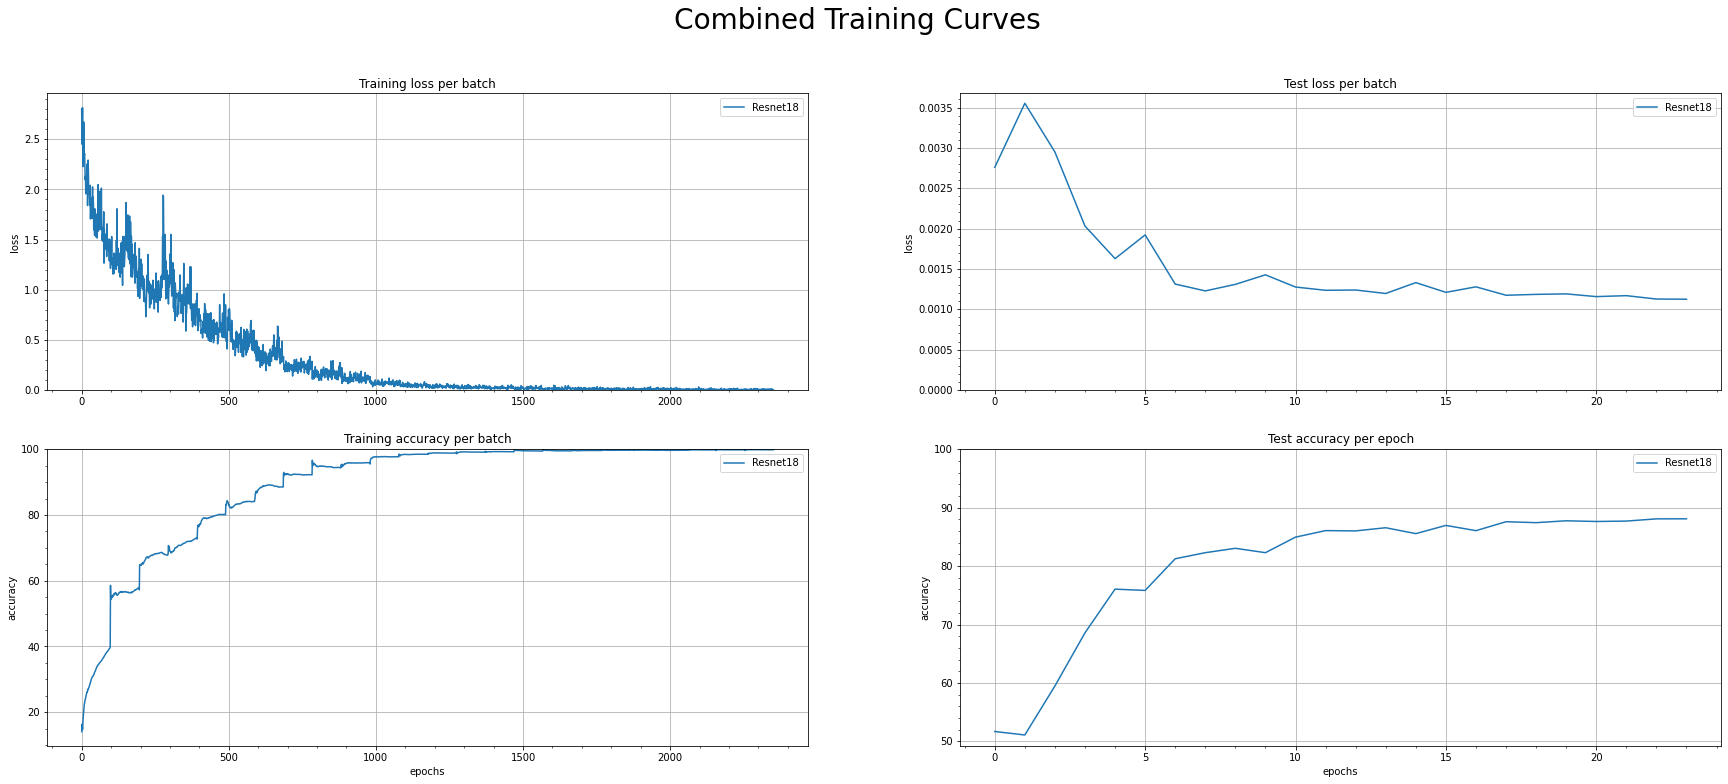

In [20]:
training_curves(history)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


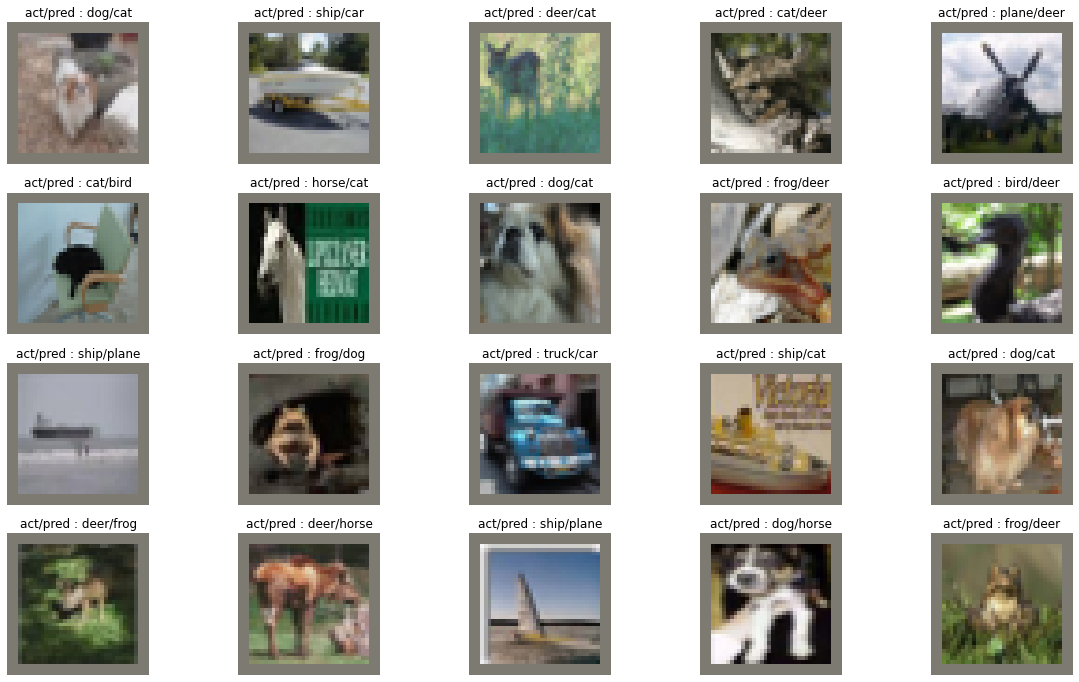

In [21]:
misclass_img_list, misclass_img_category = show_misclassified(model, test_loader, device, classes, num_of_images=20)